# Geographies experiment

Author: Mo Al Elew

Allstate had a clear geography match. ZCTAs minimized the internal variation of rates without grouping a vast number of gridded units into a single Census geography. Allstate introduced the use of gridded location zones in a [2020 filing](https://www.documentcloud.org/documents/24538162-07a-mi-ppa-afcic-mand-11-imp005182020-allstate-explanation-of-location-zone-system-alse-132230463#document/p1/a2556075). In the filing, Allstate says the location zone base rates were "calculated as land-area-weighted current Territorial Base Rates" with current territorial base rates being the zip code based rates.

**What notebook does/produces:**

I match the rate table data to tract, block group, block, and ZCTA. I plot a linear regression and scatter plot with proportion Black and White compared to location rate. I am looking for whether any signal is retained as we use smaller geographies or if the plot is a noisy mess. I also calculate the pearson correlation coeffients.

**Issue/problem being solved:**

Which Census geography to match on for a demographic analysis

**Strategy to solve:**

1. Read in data
2. Merge rate table and demographic data
3. Generate report with basic stats about the distribution of points with geographies and the variance of location-set base rates within geographies
7. Repeat 1-3 for each geography

**Conclusion**

Similar to previous visual inspection, ZCTA was the best match for a demographic analysis.

In [1]:
import geopandas as gpd
import pandas as pd
import seaborn as sns

# Constants

In [2]:
TRACT_GIS_FP = "../01_demographics/outputs/tract_demographics_map.geojson"
BG_GIS_FP = "../01_demographics/outputs/blocks_demographics_map.geojson"
BLOCK_GIS_FP = "../01_demographics/outputs/blocks_demographics_map.zip"
ZCTA_GIS_FP = "../01_demographics/outputs/zcta_demographics_map.geojson"

RATE_TABLE_FP = "./outputs/allstate_auto.csv"
COLS_TO_READ = [
    "company",
    "vehicle_type",
    "geography_type",
    "geography_factor_id",
    "latitude",
    "longitude",
    "generic_location_based_premium",
]

WAYNE_COUNTY_FIPS = "26163"

In [3]:
def population_lost(gdf_geo, gdf_merge, pop_col="total_pop"):
    failed_to_match = ~gdf_geo["geo_id"].isin(gdf_merge["geo_id"].unique())
    failed_pop_pct = (
        round(gdf_geo[failed_to_match][pop_col].sum() / gdf_geo[pop_col].sum(), 2) * 100
    )
    print(
        f"{failed_pop_pct} percent of the state population did not match to an insurance territory"
    )

# Read rate data

In [4]:
DF_GRID = pd.read_csv(RATE_TABLE_FP, usecols=COLS_TO_READ)
DF_GRID

,company,vehicle_type,geography_type,geography_factor_id,latitude,longitude,generic_location_based_premium
0,Allstate,Auto,coordinate,N4822552W08836531,48.22552,-88.36531,6965.24
1,Allstate,Auto,coordinate,N4823109W08835580,48.23109,-88.35580,6965.24
2,Allstate,Auto,coordinate,N4823530W08834466,48.23530,-88.34466,6965.24
3,Allstate,Auto,coordinate,N4822421W08836573,48.22421,-88.36573,6965.24
4,Allstate,Auto,coordinate,N4822450W08836423,48.22450,-88.36423,6965.24
...,...,...,...,...,...,...,...
78010,Allstate,Auto,coordinate,N4169917W08472783,41.69917,-84.72783,7401.56
78011,Allstate,Auto,coordinate,N4169938W08471294,41.69938,-84.71294,7401.56
78012,Allstate,Auto,coordinate,N4169960W08469819,41.69960,-84.69819,7401.56
78013,Allstate,Auto,coordinate,N4169980W08468402,41.69980,-84.68402,7401.56


# Convert to GeoDataFrame

In [5]:
gdf_rate_table = gpd.GeoDataFrame(
    DF_GRID,
    geometry=gpd.points_from_xy(DF_GRID["longitude"], DF_GRID["latitude"]),
)

# Tracts 

In [6]:
GDF_TRACTS = gpd.read_file(TRACT_GIS_FP)
GDF_TRACTS = GDF_TRACTS[GDF_TRACTS["total_pop"] > 0]

In [7]:
gdf_rate_table_tracts = gdf_rate_table.sjoin(
    GDF_TRACTS, how="inner", predicate="intersects"
)

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:2195: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


In [8]:
def generate_report(gdf_geo_merged, geography="geographic unit", groupby="geo_id"):
    geography_count = gdf_geo_merged["geo_id"].nunique()
    gdf_point_summary = gdf_geo_merged.groupby(groupby)[
        "generic_location_based_premium"
    ].describe()
    gdf_point_summary["var"] = round(
        gdf_geo_merged.groupby(groupby)["generic_location_based_premium"].var()
    )
    gdf_point_summary["range"] = gdf_point_summary["max"] - gdf_point_summary["min"]

    avg_count = round(gdf_point_summary["count"].mean())
    med_count = round(gdf_point_summary["count"].median())
    value_count = gdf_point_summary["count"].value_counts()
    single_point_tract_pct = (
        round(value_count[1] / len(gdf_point_summary.index), 3) * 100
    )

    largest_intra_unit_range = gdf_point_summary[
        gdf_point_summary["range"] == gdf_point_summary["range"].max()
    ].iloc[0]
    largest_intra_unit_range_val = gdf_point_summary["range"].max()
    largest_intra_unit_range_count = largest_intra_unit_range["count"]
    largest_intra_unit_range_name = largest_intra_unit_range.name

    largest_intra_unit_var = gdf_point_summary[
        gdf_point_summary["var"] == gdf_point_summary["var"].max()
    ].iloc[0]
    largest_intra_unit_var_val = gdf_point_summary["var"].max()
    largest_intra_unit_var_count = largest_intra_unit_var["count"]
    largest_intra_unit_var_name = largest_intra_unit_var.name

    print(f"There are {geography_count} {geography}s.\n")
    print(f"{single_point_tract_pct}% of {geography}s contain a single gridded unit.\n")
    print(
        f"The range of units within {geography} is {gdf_point_summary['count'].min()} to {gdf_point_summary['count'].max()}.\n"
    )
    print(f"On average, there is {avg_count} points within a {geography}.\n")
    print(f"The median {geography} has {med_count} gridded units in it.\n")
    print(
        f"The largest location rate range within a single {geography} is {largest_intra_unit_range_val} among {largest_intra_unit_range_count} units in {largest_intra_unit_range_name}.\n"
    )
    print(
        f"The largest location rate variance within a single {geography} is {largest_intra_unit_var_val} among {largest_intra_unit_var_count} units in {largest_intra_unit_var_name}.\n"
    )
    return gdf_point_summary

In [9]:
tract_summary = generate_report(gdf_rate_table_tracts, "tract")
population_lost(GDF_TRACTS, gdf_rate_table_tracts)
tract_summary

There are 2554 tracts.

27.0% of tracts contain a single gridded unit.

The range of units within tract is 1.0 to 1028.0.

On average, there is 30 points within a tract.

The median tract has 4 gridded units in it.

The largest location rate range within a single tract is 7503.979999999999 among 24.0 units in 26163589300.

The largest location rate variance within a single tract is 10912294.0 among 24.0 units in 26163589300.

10.0 percent of the state population did not match to an insurance territory


,count,mean,std,min,25%,50%,75%,max,var,range
geo_id,,,,,,,,,,
26001000100,91.0,8634.435165,2.189914e+02,8102.44,8622.88,8738.12,8763.85,8778.28,47957.0,675.84
26001970100,114.0,7997.514912,1.726612e+02,7811.56,7811.56,8102.44,8129.40,8404.34,29812.0,592.78
26001970400,223.0,8071.986547,1.319461e+02,7811.56,8071.52,8102.44,8196.86,8196.86,17410.0,385.30
26001970500,475.0,7656.991453,4.890344e+02,6968.44,7238.46,7763.02,8074.96,8778.28,239155.0,1809.84
26001970600,45.0,8577.602222,5.470345e+02,7904.80,8196.86,8196.86,9337.66,9358.48,299247.0,1453.68
...,...,...,...,...,...,...,...,...,...,...
26165380400,99.0,7521.474747,4.448367e+01,7328.18,7523.08,7523.08,7523.08,7609.50,1979.0,281.32
26165380500,70.0,7528.710571,2.482271e+01,7503.98,7523.08,7523.08,7523.08,7716.92,616.0,212.94
26165380600,2.0,7523.080000,0.000000e+00,7523.08,7523.08,7523.08,7523.08,7523.08,0.0,0.00


<Axes: xlabel='count', ylabel='Percent'>

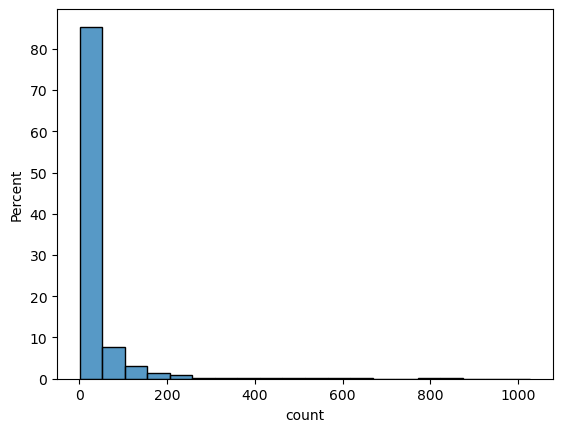

In [10]:
sns.histplot(data=tract_summary, x="count", stat="percent", bins=20)

# ZCTA

In [11]:
GDF_ZCTA = gpd.read_file(ZCTA_GIS_FP)
GDF_ZCTA = GDF_ZCTA[GDF_ZCTA["total_pop"] > 0]

In [12]:
gdf_rate_table_zcta = gdf_rate_table.sjoin(
    GDF_ZCTA, how="inner", predicate="intersects"
)

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:2195: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


In [13]:
zcta_summary = generate_report(gdf_rate_table_zcta, "zcta")
population_lost(GDF_ZCTA, gdf_rate_table_zcta)
zcta_summary

There are 962 zctas.

3.4000000000000004% of zctas contain a single gridded unit.

The range of units within zcta is 1.0 to 980.0.

On average, there is 80 points within a zcta.

The median zcta has 53 gridded units in it.

The largest location rate range within a single zcta is 6704.759999999999 among 92.0 units in 860Z200US48111.

The largest location rate variance within a single zcta is 3025803.0 among 38.0 units in 860Z200US48164.

0.0 percent of the state population did not match to an insurance territory


,count,mean,std,min,25%,50%,75%,max,var,range
geo_id,,,,,,,,,,
860Z200US48001,34.0,9822.955294,343.541697,9151.86,9905.110,10012.12,10012.12,10012.12,118021.0,860.26
860Z200US48002,48.0,10388.173750,62.322931,10195.22,10331.025,10423.62,10423.62,10423.62,3884.0,228.40
860Z200US48003,46.0,10800.354783,172.264460,10270.14,10782.575,10888.74,10888.74,10926.26,29675.0,656.12
860Z200US48005,48.0,10440.588333,99.344751,10132.12,10462.520,10482.34,10482.34,10482.34,9869.0,350.22
860Z200US48006,91.0,10241.176484,64.962782,9814.08,10262.700,10262.70,10262.70,10262.70,4220.0,448.62
...,...,...,...,...,...,...,...,...,...,...
860Z200US49968,359.0,7900.201170,28.349048,7529.32,7899.280,7899.28,7899.28,8221.02,804.0,691.70
860Z200US49969,393.0,8593.669415,22.706648,8420.26,8594.520,8594.52,8594.52,8660.22,516.0,239.96
860Z200US49970,122.0,7020.180656,550.608527,6112.84,6265.930,7375.84,7375.84,7417.90,303170.0,1305.06


# Block groups

In [14]:
GDF_BG = gpd.read_file(BG_GIS_FP)

In [15]:
gdf_rate_table_bg = gdf_rate_table.sjoin(GDF_BG, how="inner", predicate="intersects")
gdf_rate_table_bg = gdf_rate_table_bg[gdf_rate_table_bg["tot_pop"] > 0]

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:2195: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


In [16]:
bg_summary = generate_report(gdf_rate_table_bg, "block group")
population_lost(GDF_BG, gdf_rate_table_bg, "tot_pop")
bg_summary

There are 38815 block groups.

72.3% of block groups contain a single gridded unit.

The range of units within block group is 1.0 to 80.0.

On average, there is 2 points within a block group.

The median block group has 1 gridded units in it.

The largest location rate range within a single block group is 2927.8 among 3.0 units in 261239701001215.

The largest location rate variance within a single block group is 2829144.0 among 3.0 units in 261239701001215.

79.0 percent of the state population did not match to an insurance territory


,count,mean,std,min,25%,50%,75%,max,var,range
geo_id,,,,,,,,,,
260010001001000,6.0,8204.50,108.228187,8102.44,8110.995,8186.18,8293.945,8336.40,11713.0,233.96
260010001001003,1.0,8102.44,NaN,8102.44,8102.440,8102.44,8102.440,8102.44,NaN,0.00
260010001001036,1.0,8305.86,NaN,8305.86,8305.860,8305.86,8305.860,8305.86,NaN,0.00
260010001001049,2.0,8289.05,1.286934,8288.14,8288.595,8289.05,8289.505,8289.96,2.0,1.82
260010001001050,2.0,8449.69,222.583073,8292.30,8370.995,8449.69,8528.385,8607.08,49543.0,314.78
...,...,...,...,...,...,...,...,...,...,...
261653807001024,1.0,7523.08,NaN,7523.08,7523.080,7523.08,7523.080,7523.08,NaN,0.00
261653808002030,1.0,7523.08,NaN,7523.08,7523.080,7523.08,7523.080,7523.08,NaN,0.00
261653808003001,1.0,7523.08,NaN,7523.08,7523.080,7523.08,7523.080,7523.08,NaN,0.00


<Axes: xlabel='count', ylabel='Percent'>

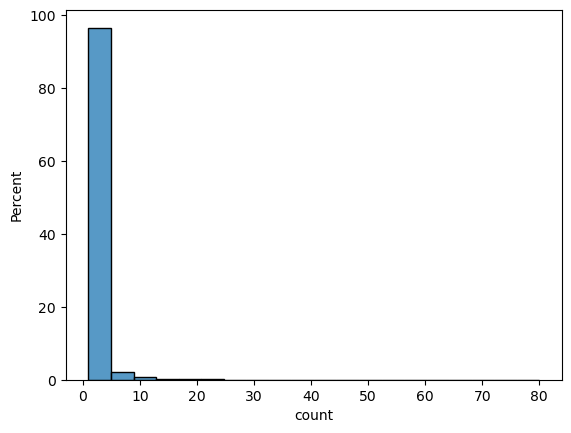

In [17]:
sns.histplot(data=bg_summary, x="count", stat="percent", bins=20)

In [18]:
# clear up some memory before reading in blocks
del GDF_BG

# Blocks

In [19]:
GDF_BLOCKS = gpd.read_file(BLOCK_GIS_FP)

In [20]:
gdf_rate_table_blocks = gdf_rate_table.sjoin(
    GDF_BLOCKS, how="left", predicate="intersects"
)
gdf_rate_table_blocks = gdf_rate_table_blocks[gdf_rate_table_blocks["tot_pop"] > 0]
gdf_rate_table_blocks

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:2195: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


,company,vehicle_type,geography_type,geography_factor_id,latitude,longitude,generic_location_based_premium,geometry,index_right,geo_id,...,other_tot,two_plus_tot,latin_pct,white_pct,black_pct,aian_pct,asian_pct,nhpi_pct,other_pct,two_plus_pct
431,Allstate,Auto,coordinate,N4747541W08803770,47.47541,-88.03770,6965.24,POINT (-88.03770 47.47541),234795.0,260830001001027,...,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
432,Allstate,Auto,coordinate,N4747588W08802681,47.47588,-88.02681,6965.24,POINT (-88.02681 47.47588),234795.0,260830001001027,...,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
433,Allstate,Auto,coordinate,N4747615W08801258,47.47615,-88.01258,6965.24,POINT (-88.01258 47.47615),237097.0,260830001001028,...,0.0,0.0,3.3,96.7,0.0,0.0,0.0,0.0,0.0,0.0
434,Allstate,Auto,coordinate,N4747641W08799702,47.47641,-87.99702,6965.24,POINT (-87.99702 47.47641),237097.0,260830001001028,...,0.0,0.0,3.3,96.7,0.0,0.0,0.0,0.0,0.0,0.0
435,Allstate,Auto,coordinate,N4747706W08798193,47.47706,-87.98193,6965.24,POINT (-87.98193 47.47706),237097.0,260830001001028,...,0.0,0.0,3.3,96.7,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78008,Allstate,Auto,coordinate,N4169874W08475771,41.69874,-84.75771,7401.56,POINT (-84.75771 41.69874),83881.0,260590512001085,...,0.0,1.0,0.0,88.9,0.0,0.0,0.0,0.0,0.0,11.1
78009,Allstate,Auto,coordinate,N4169895W08474276,41.69895,-84.74276,7401.56,POINT (-84.74276 41.69895),252191.0,260590512002044,...,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
78010,Allstate,Auto,coordinate,N4169917W08472783,41.69917,-84.72783,7401.56,POINT (-84.72783 41.69917),252191.0,260590512002044,...,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
78011,Allstate,Auto,coordinate,N4169938W08471294,41.69938,-84.71294,7401.56,POINT (-84.71294 41.69938),43176.0,260590512002045,...,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
block_summary = generate_report(gdf_rate_table_blocks, "block", groupby="geo_id")
population_lost(GDF_BLOCKS, gdf_rate_table_blocks, "tot_pop")

There are 38815 blocks.

72.3% of blocks contain a single gridded unit.

The range of units within block is 1.0 to 80.0.

On average, there is 2 points within a block.

The median block has 1 gridded units in it.

The largest location rate range within a single block is 2927.8 among 3.0 units in 261239701001215.

The largest location rate variance within a single block is 2829144.0 among 3.0 units in 261239701001215.

79.0 percent of the state population did not match to an insurance territory


In [22]:
block_summary

,count,mean,std,min,25%,50%,75%,max,var,range
geo_id,,,,,,,,,,
260010001001000,6.0,8204.50,108.228187,8102.44,8110.995,8186.18,8293.945,8336.40,11713.0,233.96
260010001001003,1.0,8102.44,NaN,8102.44,8102.440,8102.44,8102.440,8102.44,NaN,0.00
260010001001036,1.0,8305.86,NaN,8305.86,8305.860,8305.86,8305.860,8305.86,NaN,0.00
260010001001049,2.0,8289.05,1.286934,8288.14,8288.595,8289.05,8289.505,8289.96,2.0,1.82
260010001001050,2.0,8449.69,222.583073,8292.30,8370.995,8449.69,8528.385,8607.08,49543.0,314.78
...,...,...,...,...,...,...,...,...,...,...
261653807001024,1.0,7523.08,NaN,7523.08,7523.080,7523.08,7523.080,7523.08,NaN,0.00
261653808002030,1.0,7523.08,NaN,7523.08,7523.080,7523.08,7523.080,7523.08,NaN,0.00
261653808003001,1.0,7523.08,NaN,7523.08,7523.080,7523.08,7523.080,7523.08,NaN,0.00


<Axes: xlabel='count', ylabel='Percent'>

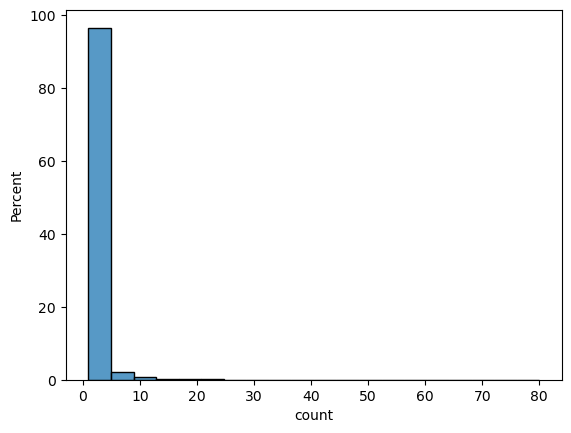

In [23]:
sns.histplot(data=block_summary, x="count", stat="percent", bins=20)